In [209]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:99%;}
div.text_cell_render.rendered_html{width:99%;}
div.CodeMirror {font-family:Consolas; font-size:19pt;}
div.output {font-size:19pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:19pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
span.toc-item-num{display:none;}
div.text_cell_render ul li{font-size:16pt;padding:5px;}
div.CodeMirror-lines > div {padding-left:10px;}
table.dataframe{font-size:18px;}
</style>
"""))

<font size="5" color="red">ch4. 머신러닝 모형 최적화</font>
# 1절. 변수 선택과 차원 축소

# 1-1. 변수 선택과 차원 축소 
- 종속변수에 영향을 주는 변수들만 찾아 학습에 사용할 독립변수의 수를 줄이는 게 목적
- 어떻게 하면 score를 높일 수 있을지가 목적
- 과적합과 독립변수들 사이의 다중공선성을 줄일 수 있음
- 모형의 학습시간을 줄일 수 있음
- 주성분분석, 상관분석, 분류모형의 feature_importance_, SelectKBest.. 등 이용

## 1-2 주성분분석(PCA, Principal Component Anaysis)
- 상관관계가 있는 변수들을 선형결합해서 상관관계가 없는 새로운 변수(주성분)로 축약하는 것

In [6]:
import seaborn as sns
from sklearn.decomposition import PCA
iris = sns.load_dataset('iris')
iris_X, iris_y = iris.iloc[:, :-1], iris.species

pca = PCA(n_components=2) # 주성분의 갯수
pca.fit(iris_X)
iris_pca = pca.transform(iris_X)
iris_pca[::50]

array([[-2.68412563,  0.31939725],
       [ 1.28482569,  0.68516047],
       [ 2.53119273, -0.00984911]])

In [7]:
pca.explained_variance_ # 설명분산:실제변수의 분산값

array([4.22824171, 0.24267075])

In [8]:
# 설명분산을 0~1사이의 비율로 나타낸 값 => 설명정도
pca.explained_variance_ratio_ 

array([0.92461872, 0.05306648])

In [9]:
pca.components_ # 각 주성분의 계수
# x1 = 0.36138659*sl -0.08452251*sw + 0.85667061*pl + 0.3582892*sw

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102]])

In [10]:
iris_X.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], dtype='object')

## 1-3 상관관계 확인
- 종속변수와 상관관계가 높은 변수들과 독립변수들끼리의 상관관계를 탐색

In [17]:
import pandas as pd
redwine = pd.read_csv('winequality-red.csv', delimiter=';') #sep=';'
redwine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


cmap : https://matplotlib.org/stable/users/explain/colors/colormaps.html <br>
heatmap : https://seaborn.pydata.org/examples/many_pairwise_correlations.html

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

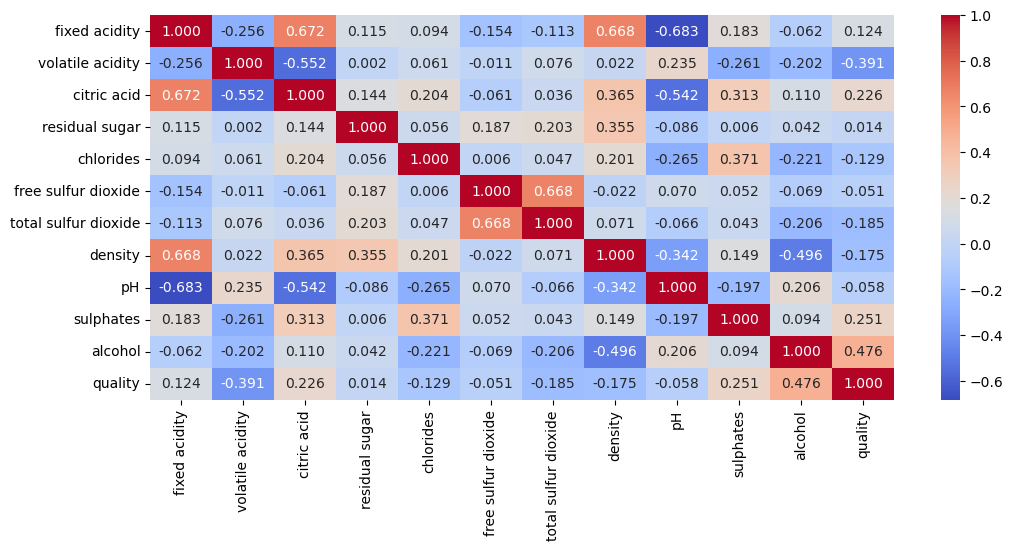

In [22]:
corr = redwine.corr()
plt.figure(figsize=(12,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.3f')
plt.show()

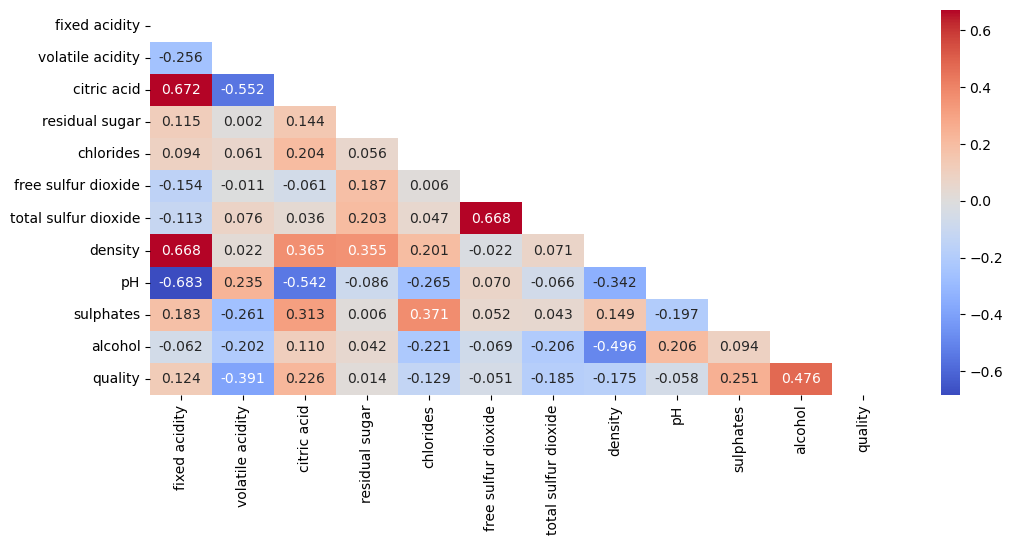

In [23]:
plt.figure(figsize=(12,5))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.3f', mask=mask)
plt.show()

## 1-4 분류모형의 feature_importances_
- 분류모형의 feature_importances_ 속성은 각 독립변수들이 종속변수에 영향을 주는 정도

In [26]:
X = redwine.iloc[:, :-1]
y = redwine.quality
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3)
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((1119, 11), (480, 11), (1119,), (480,))

In [35]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=10, #의사결정나무 갯수
                                 random_state=10)
rf_model.fit(train_X, train_y)

RandomForestClassifier(n_estimators=10, random_state=10)

In [36]:
rf_model.feature_importances_

array([0.07283599, 0.10534023, 0.08458888, 0.06511388, 0.082146  ,
       0.07412673, 0.10672823, 0.08727329, 0.07287356, 0.10958644,
       0.13938676])

In [37]:
X.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [43]:
features = pd.DataFrame(data = np.c_[X.columns, rf_model.feature_importances_],
                        columns=['feature','importance'])
features.sort_values(by='importance', ascending=False, inplace=True)
features.reset_index(drop=True, inplace=True)
features.set_index(drop=True, keys='feature')

,importance
feature,
alcohol,0.139387
sulphates,0.109586
total sulfur dioxide,0.106728
volatile acidity,0.10534
density,0.087273
citric acid,0.084589
chlorides,0.082146
free sulfur dioxide,0.074127
pH,0.072874


In [44]:
features

,feature,importance
0,alcohol,0.139387
1,sulphates,0.109586
2,total sulfur dioxide,0.106728
3,volatile acidity,0.10534
4,density,0.087273
5,citric acid,0.084589
6,chlorides,0.082146
7,free sulfur dioxide,0.074127
8,pH,0.072874
9,fixed acidity,0.072836


### feature_importance_를 이용한 변수 중요도 시각화

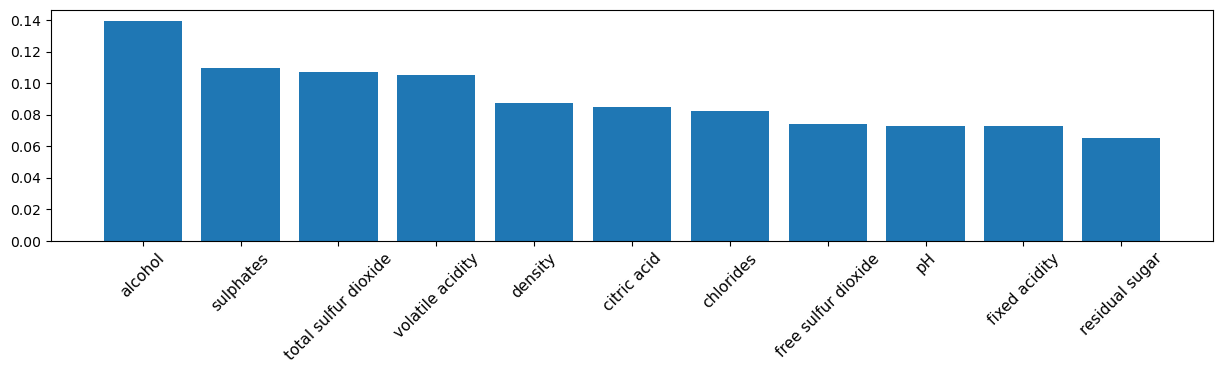

In [50]:
plt.figure(figsize=(15,3))
plt.bar(features.feature, features.importance)
plt.xticks(rotation=45, fontsize=11)
plt.show()

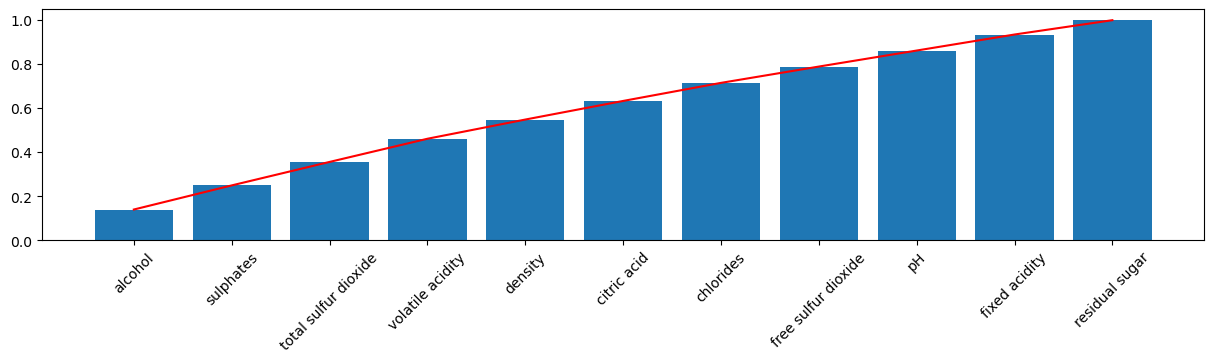

In [58]:
# feature_importance_를 누적한 시각화
y_stack = np.cumsum(features.importance)
plt.figure(figsize=(15,3))
plt.bar(features.feature, y_stack)
plt.plot(features.feature, y_stack, color='red')
plt.xticks(rotation=45)
plt.show()

### RFE(Recursive Feature Elimination) 방식
- RFE클래스를 이용하면 중요도가 낮은 변수부터 하나씩 제거해 나가면서 최종적으로 선택하고자 하는 변수의 개수만큼 중요도가 높은 변수를 찾는다(재귀적 특징 제거)

In [59]:
# feature_importance_에 의해 5개 특징이 남을 때까지 하나씩 제거
# 순위는 모르고 선택된 특징만 알 수 있다
from sklearn.feature_selection import RFE
rfe_model = RFE(RandomForestClassifier(n_estimators=10,
                                      random_state=10),
               n_features_to_select=5)
rfe_model.fit(train_X, train_y)

RFE(estimator=RandomForestClassifier(n_estimators=10, random_state=10),
    n_features_to_select=5)

In [63]:
rfe_model.get_support() # 선택된 변수인지 여부

array([False,  True, False, False, False, False,  True,  True, False,
        True,  True])

In [66]:
X.columns[rfe_model.get_support()] #선택된 변수들

Index(['volatile acidity', 'total sulfur dioxide', 'density', 'sulphates',
       'alcohol'],
      dtype='object')

In [68]:
# 선택된 변수와 선택되지 못한 변수
features_rfe = pd.DataFrame(data=np.c_[X.columns,
                                      rfe_model.get_support()],
                           columns=['feature', 'selected'])
features_rfe.sort_values(by='selected', ascending=False)

,feature,selected
1,volatile acidity,True
6,total sulfur dioxide,True
7,density,True
9,sulphates,True
10,alcohol,True
0,fixed acidity,False
2,citric acid,False
3,residual sugar,False
4,chlorides,False
5,free sulfur dioxide,False


## 1-5 SelectKBest
- 가장 높은 통계 score에 따라 K개 특징 선택

In [75]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest, chi2
X, y = load_iris(return_X_y=True)
X.shape, y.shape, y[0]

((150, 4), (150,), 0)

In [81]:
# y는 범주형, X는 연속형일 때 적합한 통계량은 chi2
X_new = SelectKBest(chi2, k=1).fit_transform(X, y)
X_new.shape

(150, 1)

In [82]:
X_new[:2] #petal_length

array([[1.4],
       [1.4]])

# 2절. 파라미터 탐색
- 하이퍼파라미터(사용자가 직접 설정할 수 있는 파라미터)
- 머신러닝 모형이 완성되었을 때 최고의 성능을 내기위한 파라미터 튜닝
- 모형 최적화

## 2-1 validation_curve
- 최적화 할 파라미터 이름과 범위, 성능기준을 각각 param_name, param_range, scoring 인수로 받아
- 모든 경우에 대해 성능을 계산

In [96]:
# 데이터
from sklearn.datasets import load_digits
digits = load_digits()
# digits.data : (1797x64) 크기의 배열
# digits.images : 1797x8x8
# digits.target : (1797,) 크기의 배열 -> 각 data샘플의 숫자0~9
# digits.target_names : 분류될 라벨들
X, y = digits.data, digits.target
X.shape, y.shape

((1797, 64), (1797,))

In [98]:
np.all(digits.data[0].reshape(8,8) == digits.images[0])

True

In [99]:
np.all(digits.data[0] == digits.images[0].ravel())

True

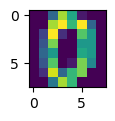

In [91]:
plt.figure(figsize=(1,1))
plt.imshow(digits.images[0])
plt.show()

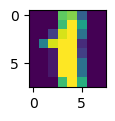

In [102]:
plt.figure(figsize=(1,1))
plt.imshow(X[1].reshape(8,8))
plt.show()

In [103]:
y[1]

1

In [105]:
y[:30]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9])

In [107]:
from sklearn.svm import SVC
model = SVC(probability=True).fit(X, y) # SVC가 판별모형이나 probability=True proba 함수 가능

In [109]:
model.predict(X[0].reshape(1, -1))

array([0])

In [110]:
model.predict_proba(X[0].reshape(1, -1))

array([[9.90992474e-01, 2.07731247e-04, 5.00015330e-04, 8.65949698e-04,
        6.78766457e-04, 1.43984671e-03, 7.62081123e-04, 9.00392487e-04,
        7.84552695e-04, 2.86819047e-03]])

In [111]:
model.score(X, y)

0.996661101836394

In [112]:
#  validation_curve 함수를 이용해서 성능이 제일 좋은 파라미터값 도출

In [113]:
# 10의 -6승 ~ 10의 -1승까지 로그간격으로 균등분포 10개 배열로 생성
param_range = np.logspace(-6, -1, 10)
param_range

array([1.00000000e-06, 3.59381366e-06, 1.29154967e-05, 4.64158883e-05,
       1.66810054e-04, 5.99484250e-04, 2.15443469e-03, 7.74263683e-03,
       2.78255940e-02, 1.00000000e-01])

In [114]:
%%time
from sklearn.model_selection import validation_curve
train_scores, test_scores = validation_curve(SVC(),
                                            X, y,
                                            param_name='gamma',
                                            param_range=param_range,
                                            cv=10, 
                                            scoring='accuracy',
                                            n_jobs=-1)
# cv=10 : 교차검증 10개중 9개는 train, 1개는 test

CPU times: total: 250 ms
Wall time: 11.9 s


In [115]:
train_scores.shape, test_scores.shape

((10, 10), (10, 10))

In [118]:
train_score_mean = np.mean(train_scores, axis=1) # train score 평균
train_score_std = np.std(train_scores, axis=1) # train score 표준편차
test_score_mean = np.mean(test_scores, axis=1) # test score 평균
test_score_std = np.std(test_scores, axis=1) # test score 표준편차
print(train_score_mean)
print(test_score_mean)

[0.13836306 0.72045751 0.93439655 0.96939318 0.98775736 0.99789765
 1.         1.         1.         1.        ]
[0.13871508 0.70395717 0.90871198 0.94264742 0.95880509 0.97495655
 0.97496586 0.80522036 0.19709497 0.10463687]


In [120]:
test_score_mean.argmax()

6

In [121]:
param_range[test_score_mean.argmax()]

0.0021544346900318843

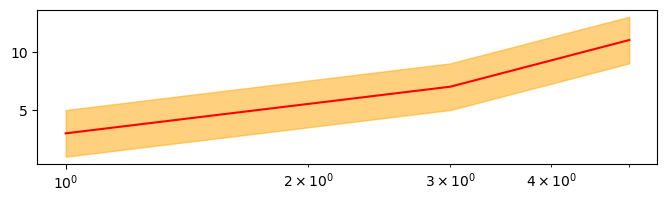

In [126]:
a = np.array([1,3,5])
b = np.array([3,7,11])
plt.figure(figsize=(8,2))
plt.semilogx(a, b, color="red")
plt.fill_between(a, b-2, b+2, alpha=0.5, color="orange")

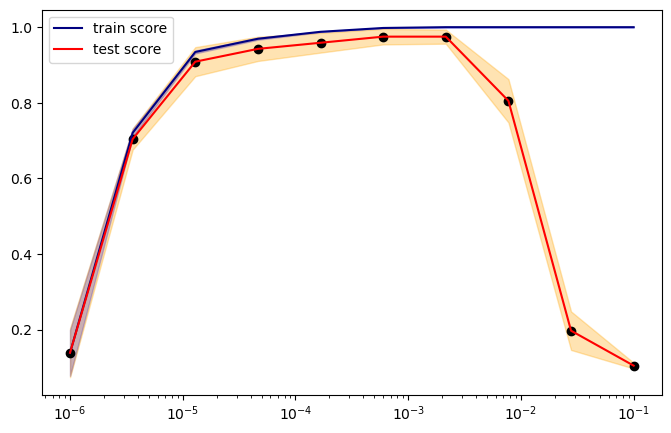

In [134]:
plt.figure(figsize=(8,5))
plt.semilogx(param_range, train_score_mean, label="train score", color='navy')
plt.fill_between(param_range, 
                train_score_mean - train_score_std,
                train_score_mean + train_score_std,
                alpha=0.3,
                color="blue")
plt.semilogx(param_range, test_score_mean, label="test score", color='red')
plt.fill_between(param_range, 
                test_score_mean - test_score_std,
                test_score_mean + test_score_std,
                alpha=0.3,
                color="orange")
plt.scatter(param_range, test_score_mean, c='k')
plt.legend(loc='best')
plt.show()

In [136]:
best_gamma = param_range[test_score_mean.argmax()]
model = SVC(gamma=best_gamma).fit(X, y)

In [137]:
model.score(X, y)

1.0

## 2-2 GridSearchCV
- 복수의 하이퍼파라미터 최적화 클래스
- validation_curve함수와 달리 모형 랩퍼 성격의 클래스(최적의 모형을 가지고 있음)
- fit(), predict(), predict_proba(), decision_function(), score()

In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pandas as pd
redwine = pd.read_csv('winequality-red.csv', delimiter=';') #sep=';'
redwine_X, redwine_y = redwine.iloc[:,:-1], redwine.quality
redwine_X.shape, redwine_y.shape

((1599, 11), (1599,))

In [8]:
%%time
selection = SelectKBest(k=1) # 가장 평가 점수가 높은 k를 찾음
svc = SVC(kernel='linear')# 가장 평가 점수가 높은 C를 찾음
pipeline = Pipeline([('select', selection),
                     ('svc', svc)])
param_grid = dict(select__k=[4, 5, 6, 7, 8, 9, 10, 11],
                 svc__C=[0.1, 1, 10])
grid_search = GridSearchCV(pipeline,
                          param_grid=param_grid,
                          cv=2,
                          verbose=10,
                          n_jobs=-1)
grid_search.fit(redwine_X.values, redwine_y)

Fitting 2 folds for each of 24 candidates, totalling 48 fits
CPU times: total: 15.1 s
Wall time: 2min 15s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('select', SelectKBest(k=1)),
                                       ('svc', SVC(kernel='linear'))]),
             n_jobs=-1,
             param_grid={'select__k': [4, 5, 6, 7, 8, 9, 10, 11],
                         'svc__C': [0.1, 1, 10]},
             verbose=10)

In [9]:
print('최적의 파라미터 정보 :', grid_search.best_params_)

최적의 파라미터 정보 : {'select__k': 9, 'svc__C': 1}


In [10]:
model = grid_search.best_estimator_

In [11]:
model.predict(redwine_X.loc[0].values.reshape(1, -1))

array([5], dtype=int64)

In [14]:
model.decision_function(redwine_X.loc[0].values.reshape(1, -1))

array([[ 0.81364186,  3.26057499,  5.29857403,  4.24990592,  1.73386464,
        -0.30285909]])

In [15]:
model.score(redwine_X.values, redwine_y)

0.5878674171357098

In [16]:
model = SVC().fit(redwine_X.values, redwine_y)
model.score(redwine_X.values, redwine_y)

0.5103189493433395

# 3절. 자료 불균형 처리
- 언더샘플링/오버샘플링
- 오버샘플링은 train 데이터에만
- SMOTE를 이용한 오버샘플링 / 모형생성시 특정 파라미터로 설정

## 3-1 SMOTE를 이용한 오버샘플링 전

In [18]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=10000, # 데이터 size
                          n_features=10, #독립변수 수
                          n_informative=5, #종속변수와 상관관계 있는 독립변수 수
                          n_redundant=0,
                          n_clusters_per_class=1,
                          n_classes=2,
                          random_state=42,
                          weights=[0.99, 0.01]  # 각 클래스의 할당된 표본 수 비율
                          )
X.shape, y.shape, y.mean()

((10000, 10), (10000,), 0.014)

In [23]:
y==1

array([False, False, False, ..., False, False, False])

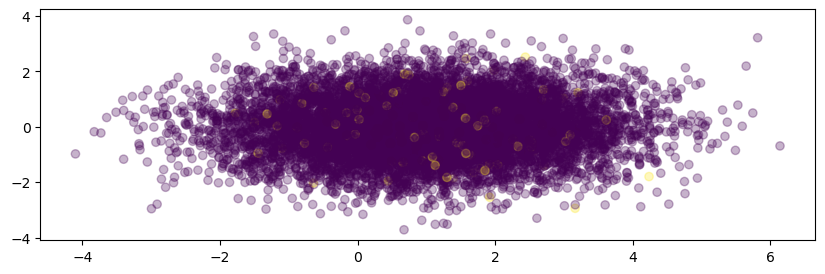

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
plt.scatter(X[:,0], X[:,1], c=y, alpha=0.3)
plt.show()

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.3,
                                                   stratify=y,
                                                   random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape, y_train.mean(), y_test.mean()

((7000, 10), (3000, 10), (7000,), (3000,), 0.014, 0.014)

In [35]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100,#학습시 생성될 의사결정나무 갯수
                                 max_features=2, # 노드 분할시 사용할 특징 최대 수
                                 random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_features=2, random_state=42)

In [37]:
from sklearn.metrics import confusion_matrix, classification_report
pred = rf_model.predict(X_test)
confusion_matrix(y_test, pred)

array([[2958,    0],
       [  34,    8]], dtype=int64)

In [39]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2958
           1       1.00      0.19      0.32        42

    accuracy                           0.99      3000
   macro avg       0.99      0.60      0.66      3000
weighted avg       0.99      0.99      0.98      3000



## 3-2 가중치 제어를 통한 모형 생성

In [60]:
rf_model = RandomForestClassifier(n_estimators=100,
                                 max_features=2,
                                 class_weight={0:1, 1:1.4} ,
                                 random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 1.4}, max_features=2,
                       random_state=42)

In [61]:
pred = rf_model.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2958
           1       1.00      0.21      0.35        42

    accuracy                           0.99      3000
   macro avg       0.99      0.61      0.67      3000
weighted avg       0.99      0.99      0.99      3000



## 3-3 SMOTE를 이용한 오버샘플링 후 
- pip install imblearn

In [62]:
X_train.shape, y_train.shape

((7000, 10), (7000,))

In [63]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
X_resampled.shape, y_resampled.shape

((13804, 10), (13804,))

In [64]:
y_resampled.mean()

0.5

In [66]:
rf_model = RandomForestClassifier(n_estimators=100,
                                 max_features=2,
                                 random_state=42)
rf_model.fit(X_resampled, y_resampled)

RandomForestClassifier(max_features=2, random_state=42)

In [67]:
pred = rf_model.predict(X_test)
confusion_matrix(y_test, pred)

array([[2955,    3],
       [  28,   14]], dtype=int64)

In [68]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2958
           1       0.82      0.33      0.47        42

    accuracy                           0.99      3000
   macro avg       0.91      0.67      0.73      3000
weighted avg       0.99      0.99      0.99      3000



# 4절. 최적 모형 탐색(앙상블 모형)
- 여러분류모델을 하나의 메타 분류모델로 연결해서 하나의 분류모델보다 더 좋은 성능을 달성
1. 한가지 분류 알고리즘을 이용 
- 배깅 (학습 잘 된 모델에 점수) : 과적합을 방지하면서 안정적인 모형이 필요할 때
- 부스팅(학습이 안 된 데이터에 가중치) : 데이터가 비교적 적거나 복잡한 패턴을 잘 학습해야 할 때
2. 여러가지 분류 알고리즘을 이용
- 투표방식(hard 방식 vs. soft방식)

## cf 배깅알고리즘 시 0.632규칙(pt. 36)

In [130]:
import numpy as np
len(set(np.random.choice(10, 10))) #10미만의 수를 10개 복원추출로 choice

7

In [182]:
N = 1000000
data = np.random.choice(N, N)
cnt = len(set(data))
print('추출된 데이터 갯수 : {}, 비율 : {:.3f}'.format(cnt, cnt/N ) )
print('추출되지 않는 데이터 갯수 : {}, 비율 : {:.3f}'.format(
                                    N - cnt, (N-cnt)/N )
     )

추출된 데이터 갯수 : 631963, 비율 : 0.632
추출되지 않는 데이터 갯수 : 368037, 비율 : 0.368


## 4-1 배깅 방식
- BaggingClassifier, RandomforestClassifier

In [186]:
wine_df = pd.read_csv('wine.csv')
wine_df['Class label'].unique()
wine_df.sample()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,0D280/0D315 of diluted wines,Proline
148,3,13.32,3.24,2.38,21.5,92,1.93,0.76,0.45,1.25,8.42,0.55,1.62,650


In [194]:
X = wine_df.iloc[:, 1:]
y = wine_df['Class label']

In [195]:
train_X, test_X, train_y, test_y = train_test_split(X, y,
                                                   test_size=0.3,
                                                   stratify=y,
                                                   random_state=1)

In [196]:
# 의사결정나무 알고리즘
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy', random_state=1)
tree.fit(train_X, train_y)
tree.score(test_X, test_y)

0.9074074074074074

In [201]:
# 배깅 알고리즘
from sklearn.ensemble import BaggingClassifier
bag = BaggingClassifier(estimator=tree,
                       n_estimators=500,
                       bootstrap=True, # 복원추출 중복추출 허용
                       bootstrap_features=False,# 모든 특성을 사용해서 학습
                       random_state=1)
bag.fit(train_X, train_y)
bag.score(test_X, test_y)

0.9629629629629629

In [202]:
# 랜덤 포레스트 알고리즘
rf = RandomForestClassifier().fit(train_X, train_y)
rf.score(test_X, test_y)

1.0

## 4-2 임의의 데이터를 만들어 최적 모형 탐색

In [2]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=10000,
                          n_features=10,
                          n_informative=5,
                          n_redundant=0,
                          n_clusters_per_class=1,
                          n_classes=2,
                          weights=[0.9,0.1],
                          random_state=42)

In [4]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
train_X, test_X, train_y, test_y = train_test_split(X, y,
                                                   test_size=0.3,
                                                   stratify=y,
                                                   random_state=42)
sm = SMOTE()
resampled_X, resampled_y = sm.fit_resample(train_X, train_y)
resampled_X.shape, resampled_y.shape

((12556, 10), (12556,))

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score
def model_measure(model, train_X=resampled_X, train_y=resampled_y, 
                  test_X=test_X, test_y=test_y):
    model.fit(train_X, train_y)
    pred = model.predict(test_X)
    accuracy = model.score(test_X, test_y)
    precision= precision_score(test_y, pred)
    recall   = recall_score(test_y, pred)
    f1score = f1_score(test_y, pred)
    return '정확도:{:.3f}, 정밀도:{:.3f}, 재현율:{:.3f}, f1 score:{:.3f}'.format(accuracy,
                                                                     precision,
                                                                     recall,
                                                                     f1score)

In [6]:
from sklearn.svm import SVC
model_measure(SVC())

'정확도:0.988, 정밀도:0.950, 재현율:0.929, f1 score:0.939'

In [7]:
from sklearn.ensemble import RandomForestClassifier
model_measure(RandomForestClassifier())

'정확도:0.983, 정밀도:0.939, 재현율:0.896, f1 score:0.917'

In [225]:
from sklearn.neural_network import MLPClassifier
model_measure(MLPClassifier(hidden_layer_sizes=(50,50), 
                           max_iter=500))

'정확도:0.982, 정밀도:0.918, 재현율:0.906, f1 score:0.912'

## 4-3  부스팅 방식

In [226]:
# pip install xgboost
from xgboost import XGBClassifier
model_measure(XGBClassifier())

'정확도:0.985, 정밀도:0.943, 재현율:0.909, f1 score:0.926'

In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [16]:
# pip install lightgbm
from lightgbm import LGBMClassifier
model_measure(LGBMClassifier(force_col_wise=True))

[LightGBM] [Info] Number of positive: 6278, number of negative: 6278
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 12556, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


'정확도:0.986, 정밀도:0.950, 재현율:0.916, f1 score:0.932'

In [233]:
from sklearn.ensemble import AdaBoostClassifier
model_measure(AdaBoostClassifier())

'정확도:0.930, 정밀도:0.605, 재현율:0.913, f1 score:0.728'